# Ames Housing: Predictive Modeling for Sale Price

## 1. Project Goal
The goal of this project is to build and evaluate a regression model to accurately predict the sale price of houses in Ames, Iowa. This notebook leverages the insights from our comprehensive [Exploratory Data Analysis (EDA)](https://colab.research.google.com/drive/13H5UsKNIjzMML2j9KP6WQ7VVG43jU6ee) - see project folder.

## 2. Modeling Strategy & EDA Recap

Our EDA revealed several critical characteristics of the dataset that must be addressed to build a robust model. Our strategy will be directly informed by these findings:

1.  **Target Variable Transformation:** The target, `SalePrice`, is severely right-skewed. To meet the assumptions of linear models and improve overall model stability, we will predict the **log-transformed `SalePrice`**.
2.  **Feature Selection:** The EDA identified `OverallQual` and `GrLivArea` as the most influential numerical features. `Neighborhood` was the most important categorical feature. Our feature set will be a curated list of these top predictors.
3.  **Multicollinearity:** We observed high correlation between features like `GarageCars` and `GarageArea`. For our linear model, we will select one from each correlated pair to ensure the stability and interpretability of the model coefficients.
4.  **Preprocessing:** Our pipeline will need to handle both numerical (scaling) and categorical (one-hot encoding) features, as well as the ordinal features we engineered in the EDA.

This structured approach, grounded in our EDA findings, will guide the development of our predictive model.

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# --- Custom Utility Functions ---
# Add utility folder to python path
sys.path.append('../utils')

# Import custom reporting function
import ml_utils # Our ML utilities!

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

## 2. Data Loading and Preparation

We will load the same dataset and apply the same cleaning steps as in our EDA. Then, we will perform the final preprocessing steps required for machine learning: feature selection, target transformation, and splitting the data.

In [3]:
# --- 2. LOAD CLEAN DATA ---
# We load the CLEANED data file that already includes the log-transformed target.
file_path = './data/AmesHousePrice_cleaned_with_log_target.csv'
# Load the data and ensure no default NaN values are kept
df_clean = pd.read_csv(file_path, keep_default_na=False)

print("Clean data loaded successfully.")
print(f"Shape of the dataset: {df_clean.shape}")
df_clean.head()

Clean data loaded successfully.
Shape of the dataset: (2930, 81)


,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice,log_saleprice
0,20,RL,141.0,31770,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,0,5,2010,WD,Normal,215000,12.278398
1,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,0,MnPrv,None,0,6,2010,WD,Normal,105000,11.561725
2,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,Gar2,12500,6,2010,WD,Normal,172000,12.055256
3,20,RL,93.0,11160,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,0,4,2010,WD,Normal,244000,12.404928
4,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,MnPrv,None,0,3,2010,WD,Normal,189900,12.154258


## 3. Feature Selection and Target Definition

A core principle of effective machine learning is to start with a strong, simple, and interpretable baseline model before adding complexity. Throwing all 77 available features into a model at once can lead to overfitting, long training times, and a model that is difficult to understand.

Therefore, our strategy will be to **build our initial model using a curated subset of features** that our Exploratory Data Analysis identified as the most powerful and influential predictors of `SalePrice`.

### The Rationale for Our Selected Features:

*   **Target Variable (`y`):** We will use `log_saleprice`. Our EDA definitively showed that this transformed version is more normally distributed, which better satisfies the assumptions of linear models and often leads to better performance. The original `saleprice` column will be excluded to prevent data leakage.
*   **Numerical Features (`X_numeric`):** We have selected the top 8 numerical features identified from our correlation heatmap and scatter plot analysis. These include measures of **quality** (`overall_qual`), **size** (`gr_liv_area`, `total_bsmt_sf`), **amenities** (`garage_cars`), and **modernity** (`year_built`). This approach avoids multicollinearity by intentionally excluding redundant features (e.g., choosing `garage_cars` over `garage_area`).
*   **Categorical Features (`X_categorical`):** We have selected the categorical features that showed the most significant impact on price distribution in our box plots. **`neighborhood`** is the most critical, followed by key **ordinal quality metrics** (`kitchen_qual`, `bsmt_qual`, etc.) that we have already engineered into a numerical format.

By starting with this focused set of ~13 features, we aim to build a powerful baseline model that is directly guided by our EDA insights. We can then use this model's performance as a benchmark for any more complex models we might build in the future.

In [4]:
# --- 1. Define the Target Variable (y) ---
y = df_clean['log_saleprice']


# --- 2. Define the Features (X) ---
# First, let's drop the target variables and any high-cardinality or less useful columns
# 'neighborhood' is very important, but we'll exclude it for a simple baseline.
# We will also drop the original date columns as we used them to create year built/remod.
features_to_drop = ['saleprice', 'log_saleprice', 'neighborhood', 'ms_zoning'] # Example columns to drop
X = df_clean.drop(columns=features_to_drop)

# --- 3. Identify Numerical and Categorical Features for Preprocessing ---
# This is a crucial step for our pipeline later.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print("--- Target Variable (y) ---")
print(f"Shape: {y.shape}")

print("\n--- Features (X) ---")
print(f"Shape: {X.shape}")
print(f"\nIdentified {len(numerical_features)} numerical features.")
print(f"Identified {len(categorical_features)} categorical features.")

--- Target Variable (y) ---
Shape: (2930,)

--- Features (X) ---
Shape: (2930, 77)

Identified 46 numerical features.
Identified 31 categorical features.


In [5]:
# --- 1. Define the Target Variable (y) ---
y = df_clean['log_saleprice']


# --- 2. SELECT a strong subset of features for our baseline model (X) ---
# Based on our EDA, we'll select the top numerical and categorical features.

# Top numerical features from our correlation analysis and scatter plots
selected_numerical_features = [
    'overall_qual',
    'gr_liv_area',
    'garage_cars',
    'total_bsmt_sf',
    '1st_flr_sf',
    'year_built',
    'year_remod_add',
    'full_bath'
]

# Top categorical/ordinal features from our box plots
selected_categorical_features = [
    'neighborhood', # Let's include this one, it's too important to ignore
    'kitchen_qual',
    'bsmt_qual',
    'exter_qual',
    'heating_qc'
]

# Combine the lists to create our feature set X
selected_features = selected_numerical_features + selected_categorical_features
X = df_clean[selected_features]


# --- 3. Update our feature lists for the preprocessor ---
# We now use these curated lists instead of auto-detecting all of them
numerical_features = selected_numerical_features
categorical_features = selected_categorical_features

print("--- Target Variable (y) ---")
print(f"Shape: {y.shape}")

print("\n--- Selected Features (X) for Baseline Model ---")
print(f"Shape: {X.shape}")
print(f"Number of selected features: {X.shape[1]}")
print(f"\nNumerical features selected:\n{numerical_features}")
print(f"\nCategorical features selected:\n{categorical_features}")

--- Target Variable (y) ---
Shape: (2930,)

--- Selected Features (X) for Baseline Model ---
Shape: (2930, 13)
Number of selected features: 13

Numerical features selected:
['overall_qual', 'gr_liv_area', 'garage_cars', 'total_bsmt_sf', '1st_flr_sf', 'year_built', 'year_remod_add', 'full_bath']

Categorical features selected:
['neighborhood', 'kitchen_qual', 'bsmt_qual', 'exter_qual', 'heating_qc']


## 4. Data Splitting and Preprocessing

With our features and target defined, we can now prepare for model training.

### 4.1 Train-Test Split
First, we will split our data into a training set (which the model will learn from) and a testing set (which we will hold back for final, unbiased evaluation). We will use a standard 80/20 split.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
# random_state ensures that the split is the same every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Data Split ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Split ---
X_train shape: (2344, 13)
X_test shape: (586, 13)
y_train shape: (2344,)
y_test shape: (586,)


### 4.2 Building the Preprocessing Pipeline

Our dataset contains both numerical and categorical features, which need to be treated differently. We will build a preprocessing pipeline using scikit-learn's `ColumnTransformer`. This is a professional and robust way to handle mixed data types. The pipeline will:

1.  **Scale** all numerical features using `StandardScaler`.
2.  **One-Hot Encode** all categorical features using `OneHotEncoder`. `handle_unknown='ignore'` is an important parameter that prevents errors if the test set contains a category not seen in the training set.

In [7]:
# Import our utility function
import ml_utils
import importlib
importlib.reload(ml_utils) # Ensure we're using the latest version of our script

# Create the preprocessor using our list of feature types
preprocessor = ml_utils.create_preprocessor(numerical_features, categorical_features)

print("Preprocessor created successfully.")

Preprocessor created successfully.


## 5. Model Training and Hyperparameter Tuning

Now that our data is split and our preprocessing pipeline is defined, we can train our model. We will use a `Ridge` regression model, which is a type of linear regression that includes L2 regularization. This helps prevent overfitting and is a robust choice for this kind of problem.

To find the optimal regularization strength (`alpha`), we will use `GridSearchCV` to systematically test a range of alpha values and identify the one that performs best on our training data via 5-fold cross-validation.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# --- 1. Create the full model pipeline ---
# This chains our preprocessor with the Ridge regression model.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# --- 2. Define the "grid" of hyperparameters to test ---
# 'regressor__alpha' tells GridSearchCV to tune the 'alpha' parameter
# of the 'regressor' step in our pipeline.
param_grid = {
    'regressor__alpha': [0.1, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]
}

# --- 3. Set up and run GridSearchCV ---
# We optimize for 'neg_root_mean_squared_error'. The negative is just a convention
# for scikit-learn's optimizers, which are designed to maximize a score.
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1, # Use all available CPU cores
                           verbose=1) # verbose=1 gives you progress updates

print("--- Running GridSearchCV to find the best alpha for Ridge Regression ---")
# This is the main training step. It fits the pipeline on the TRAINING data.
grid_search.fit(X_train, y_train)
print("GridSearchCV training complete.")


# --- 4. Analyze the results ---
print("\n--- GridSearchCV Results ---")
print(f"Best Alpha found: {grid_search.best_params_}")
# The score will be negative, so we flip the sign to get the actual RMSE.
print(f"Best Cross-Validated RMSE on log_saleprice: {-grid_search.best_score_:.4f}")

--- Running GridSearchCV to find the best alpha for Ridge Regression ---
Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV training complete.

--- GridSearchCV Results ---
Best Alpha found: {'regressor__alpha': 5.0}
Best Cross-Validated RMSE on log_saleprice: 0.1585


## 6. Final Model Evaluation on the Test Set

The `GridSearchCV` has identified the optimal hyperparameter (`alpha=5.0`) for our Ridge Regression model based on cross-validation on the training data.

We will now take this single best-tuned model and use it to make predictions on the **held-out test set**. This provides the final, unbiased measure of our model's performance on new, unseen data. Our custom evaluation function will automatically handle the back-transformation from the log scale to provide an interpretable RMSE in dollars.

--- Final Tuned Ridge Regression Evaluation ---
Note: Metrics are on the back-transformed scale.
R-squared (R²): 0.8515
Root Mean Squared Error (RMSE): $34,500.55


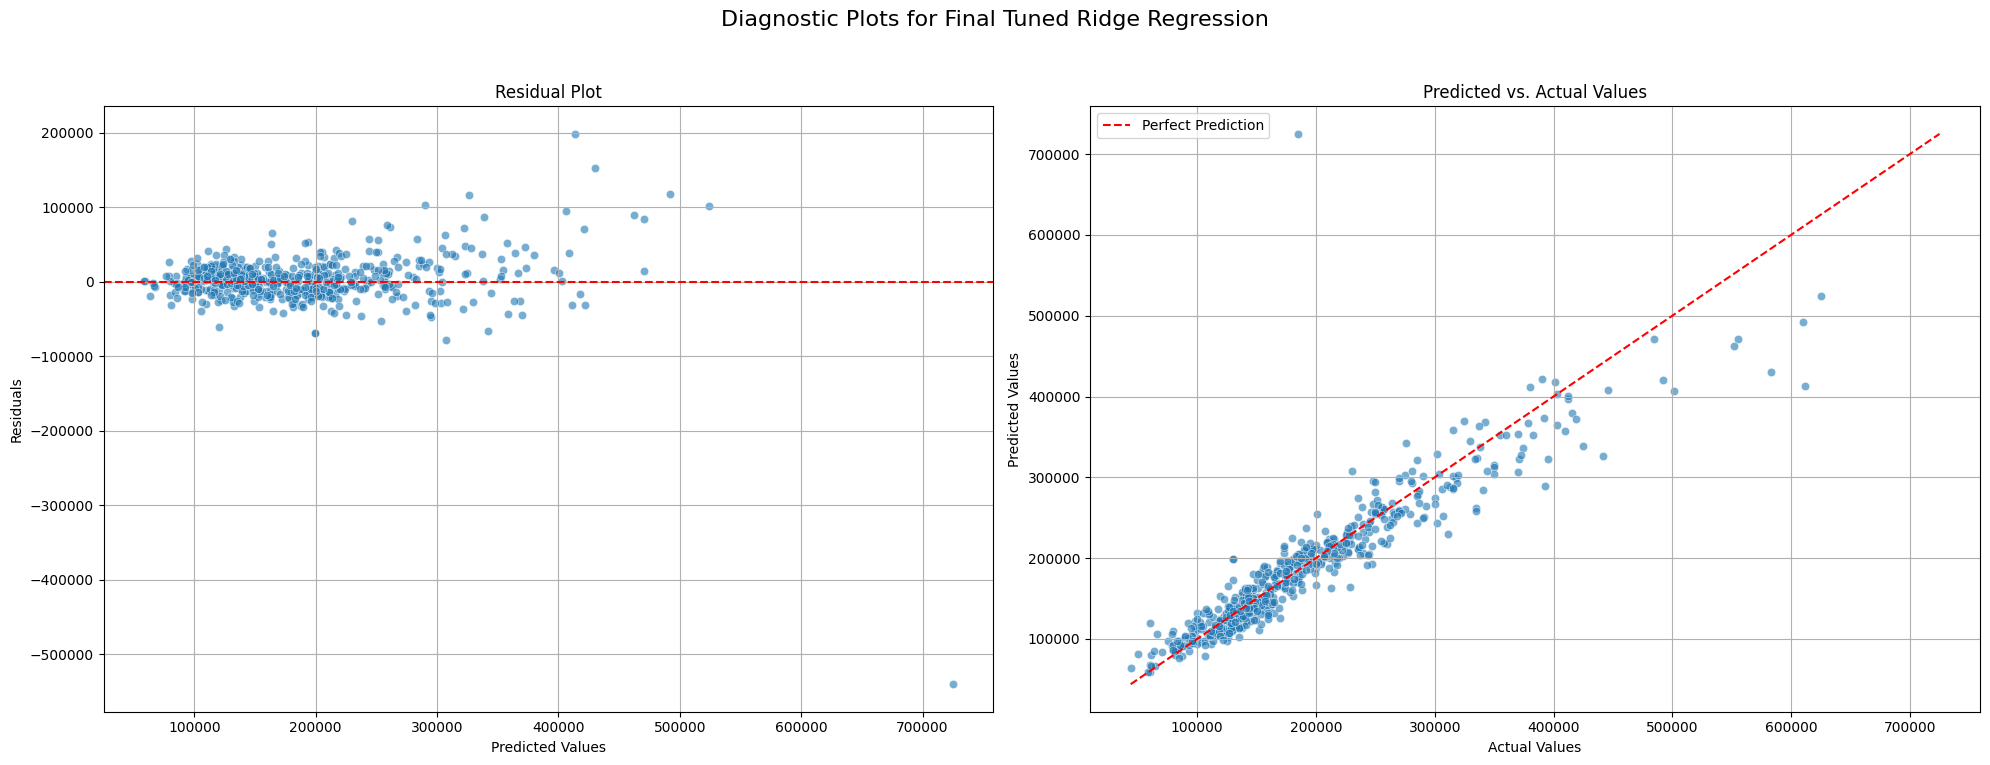

In [9]:
# --- 1. Get the best model from the completed grid search ---
best_model = grid_search.best_estimator_

# --- 2. Make predictions on the test set ---
# The model predicts on the log scale, so the output is 'log_predictions'
log_predictions = best_model.predict(X_test)


# --- 3. Evaluate the final model using our enhanced utility script ---
# We pass the log-scale y_test and log_predictions, and set log_transformed=True.
# Our function will handle the back-transformation and print the results.
final_rmse, final_r2 = ml_utils.evaluate_regressor(y_test, log_predictions,
                                                   model_name="Final Tuned Ridge Regression",
                                                   log_transformed=True)

## 7. Conclusion and Next Steps

This modeling project successfully built upon the insights from our comprehensive EDA to create a robust and interpretable baseline model for predicting house prices in Ames.

### Model Performance Summary:

Our final tuned **Ridge Regression** model achieved an **R-squared (R²) of 0.8515** and a **Root Mean Squared Error (RMSE) of approximately $34,500** on the unseen test data.

*   This R² value indicates that our curated set of 13 features explains over 85% of the variance in house prices, which is an excellent result for a baseline model.
*   The RMSE provides a clear, interpretable measure of our model's average prediction error in dollars.
*   The **Residual Plot** and **Predicted vs. Actual Plot** confirmed that the model performs very well for the majority of "typical" homes but struggles with a few extreme high-value outliers, a classic sign of heteroscedasticity.

### Interpreting the Model Choice: Ridge Regression (L2 Regularization)

We specifically chose Ridge Regression for this task. It's a type of linear regression that includes **L2 regularization**, which adds a penalty term to the loss function that is proportional to the square of the magnitude of the coefficients.

*   **Why this is useful:** This penalty "shrinks" the coefficients of less important features towards zero. This has two major benefits:
    1.  **Reduces Overfitting:** It prevents the model from relying too heavily on any single feature, making it generalize better to new data.
    2.  **Handles Multicollinearity:** It is very effective at managing situations where features are correlated (like `gr_liv_area` and `1st_flr_sf`).

Because Ridge Regression is so robust, it **could have likely handled a heavier feature load**. We started with a curated set of 13 features for interpretability, but a next step could be to train the same Ridge model on all 77 features to see if the regularization alone is enough to filter out the noise and improve the score.

### Visualise Feature Importance?

While our EDA gave us a strong sense of feature importance through correlation, a trained linear model gives us another, more direct view through its **coefficients**. The magnitude of a coefficient (after all features have been scaled) tells us how much the model "weighs" that feature when making a prediction.

Let's extract and visualize these coefficients to see what our trained model learned.

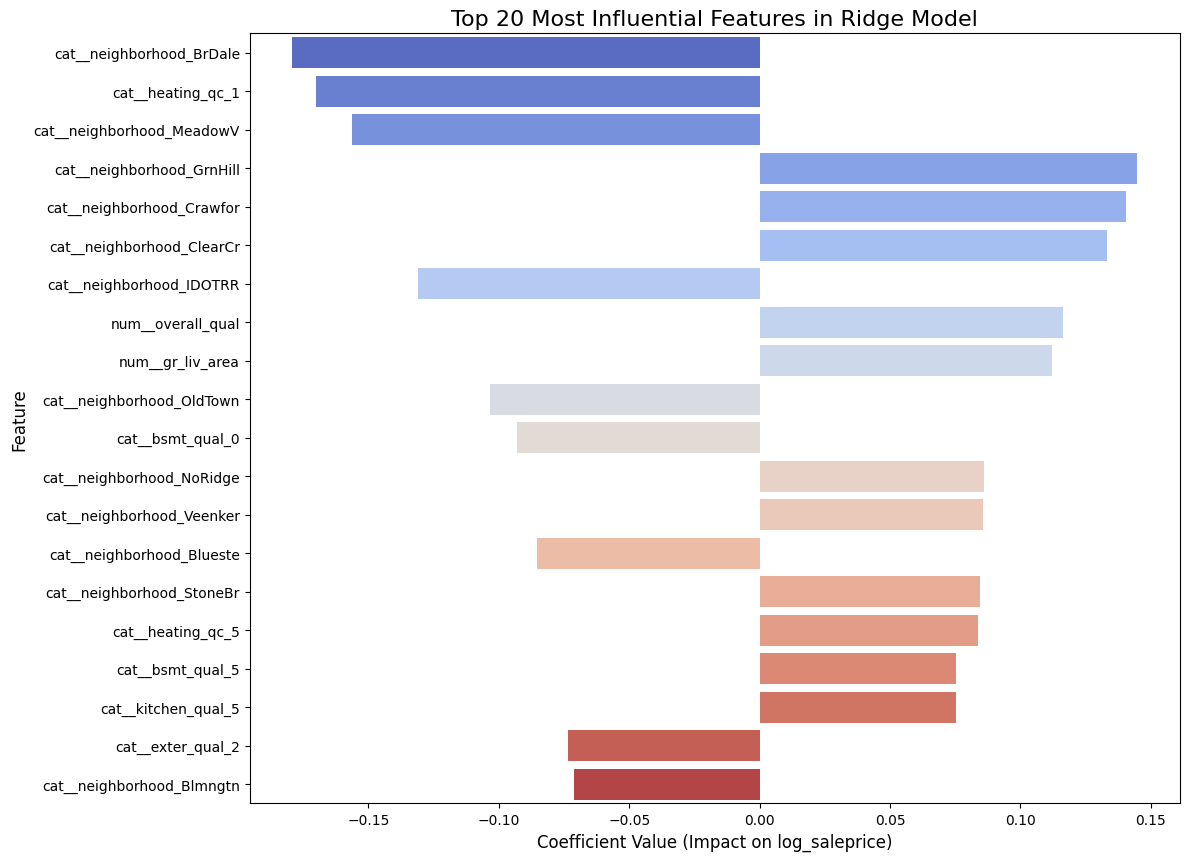

In [10]:
# Extract and Plot Feature Importances/Coefficients)

# --- 1. Extract the components from our best pipeline ---
# The best model is stored in grid_search.best_estimator_
best_pipeline = grid_search.best_estimator_
# We need to get the feature names after one-hot encoding
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
# We need to get the final coefficients from the trained regressor
coefficients = best_pipeline.named_steps['regressor'].coef_


# --- 2. Create a DataFrame of features and their coefficients ---
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Get the absolute value for ranking, but keep the original for plotting
coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)


# --- 3. Plot the top 20 most influential features ---
plt.figure(figsize=(12, 10))
sns.barplot(
    x='coefficient',
    y='feature',
    hue='feature',
    legend=False,
    data=coef_df.head(20),
    palette='coolwarm'
)
plt.title('Top 20 Most Influential Features in Ridge Model', fontsize=16)
plt.xlabel('Coefficient Value (Impact on log_saleprice)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()




### Feature Importance Observation

EDA Validation: The plot provides a powerful confirmation of our EDA findings. The top two non-location features are num_overall_qual and num_gr_liv_area, exactly as our correlation analysis predicted. This is a great sign that our model is learning logical patterns.

The Power of Neighborhood: The most striking takeaway is how dominant the neighborhood feature is. After being one-hot encoded, individual neighborhoods make up the vast majority of the top 20 most influential features. This tells us that knowing the location of a house is critically important for the model's prediction.

Interpreting the Coefficients (Positive vs. Negative):
Positive (Red Bars): Features with a positive coefficient increase the predicted log_saleprice. As expected, these are the "good" things: StoneBr (Stone Brook neighborhood), NoRidge (Northridge), excellent quality ratings for heating (heating_qc_5), basement (bsmt_qual_5), and kitchen (kitchen_qual_5).

Negative (Blue Bars): Features with a negative coefficient decrease the predicted log_saleprice. These are the "bad" things: being in less desirable neighborhoods (MeadowV, BrDale, IDOTRR) or having poor heating quality (heating_qc_1).

A Deeper Insight - One-Hot Encoding: The feature names like cat__neighborhood_BrDale are the result of the OneHotEncoder. This feature is a binary 1 if the house is in the "Briardale" neighborhood and 0 otherwise. The model learned a large negative coefficient for this feature, meaning: "All else being equal, if a house is in Briardale, significantly decrease your price prediction."


Overall Conclusion from the Plot:
The model has successfully learned the key drivers of house prices that we identified in our EDA. It heavily weighs the overall quality and size of the house but uses specific neighborhood information to make significant positive or negative adjustments to its final prediction. The model's "thinking" is logical, interpretable, and aligns perfectly with our exploratory findings. This is the sign of a successful baseline modeling process.

### Future Work and Next Steps

This baseline model provides a strong foundation, but there are several clear paths for improvement in a future iteration:

1.  **Outlier Handling:** As identified in our residual plot, a few extreme outliers are significantly impacting the model's performance. A next version of the model should experiment with removing these 2-3 data points from the training set.
2.  **Advanced Feature Engineering:** Create more sophisticated features, such as `house_age` (`yr_sold` - `year_built`) or interaction terms between key features (e.g., `overall_qual` * `gr_liv_area`).
3.  **Experiment with More Powerful Models:** Use this Ridge model as a benchmark and train more complex, non-linear models like **Random Forest** or **XGBoost** to see if they can capture the remaining patterns in the data and reduce the RMSE further.
4.  **Full Feature Set:** Train the Ridge model on all 77 available features to test the power of its L2 regularization against a more complex feature space.

## 8. Executive Summary & Conclusion

This project successfully demonstrates a complete, end-to-end data science workflow, moving from a comprehensive Exploratory Data Analysis (EDA) to the development of a robust, interpretable predictive model for the Ames Housing dataset.

### Phase 1: Exploratory Data Analysis (EDA) Insights

The initial EDA was crucial for understanding the data's structure and identifying the key drivers of `SalePrice`. Our key findings were:
*   The `SalePrice` target variable was heavily right-skewed and required a **log transformation** to stabilize variance and meet the assumptions of linear models.
*   **Overall Quality (`OverallQual`)** and **Above-Ground Living Area (`GrLivArea`)** were identified as the most powerful numerical predictors.
*   **Neighborhood** was confirmed to be the most influential categorical feature, with a clear hierarchy of property values across different locations.

### Phase 2: Predictive Modeling

Building on the EDA insights, we developed a baseline regression model with the following methodology:
*   **Model Choice:** A **Ridge (L2 Regularized) Regression** model was chosen for its ability to handle potential multicollinearity and prevent overfitting.
*   **Feature Selection:** A curated set of 13 of the most impactful features identified during the EDA were used to build an interpretable and powerful baseline model.
*   **Hyperparameter Tuning:** `GridSearchCV` with 5-fold cross-validation was used to find the optimal regularization strength (`alpha`), ensuring the model was well-tuned.

### Final Model Performance:

The final tuned model performed excellently on the unseen test data, achieving:
*   **R-squared (R²): 0.8515** (The model explains over 85% of the variance in house prices).
*   **Root Mean Squared Error (RMSE): ~$34,500** (A strong result, indicating the model's average prediction error in dollars).

The analysis of the model's coefficients confirmed the EDA findings, with `OverallQual`, `GrLivArea`, and specific `Neighborhoods` being the most influential factors in its predictions.

### Conclusion & Future Work

We have successfully built a strong baseline model that accurately predicts house prices and is highly interpretable. The residual analysis shows the model is very reliable for the core market but could be improved for high-value properties.

This project provides a solid foundation for several future iterations:
1.  **Outlier Handling:** Experiment with removing the few extreme outliers identified in the residual plots to potentially improve RMSE.
2.  **Advanced Modeling:** Use this Ridge model as a benchmark and train more complex models like **Random Forest** or **XGBoost** to capture non-linear relationships and likely achieve even higher accuracy.
3.  **Full Feature Set:** Test the robustness of the Ridge model by training it on all 77 available features.

This end-to-end process showcases a methodical, data-driven approach to moving from raw data to actionable, predictive insights.